In [2]:
import numpy as np
import numpy.linalg as npl
import numpy as np
from scipy.sparse import diags

In [54]:
def modNewtonBcktrck(x0, f, gradf, hessf, alpha0, kmax, tolgrad, c1, rho, btmax):
    xk = x0.copy()
    k = 0
    
    # Store the sequence of iterates
    xseq = [xk.copy()]
    grad_xk = gradf(xk)
    gradfk_norm = npl.norm(grad_xk)
    n = len(x0) # Dimensione del problema
    while k < kmax and gradfk_norm > tolgrad:
        H = hessf(xk)
        # --- INIZIO MODIFICA PER NEWTON MODIFICATO ---
        # Cerchiamo di rendere H definita positiva aggiungendo tau * I
        tau = 0
        beta = 1e-3  # Valore iniziale piccolo se tau deve essere aumentato
        while True:
            # Creiamo la matrice modificata: B = H + tau * I
            B = H + tau * np.eye(n)
            #IMPORTANTE contare le volte che viene modificata la matrice
            try:
                # Proviamo la fattorizzazione di Cholesky.
                # Se funziona, B è definita positiva.
                # Se lancia LinAlgError, B non è definita positiva.
                np.linalg.cholesky(B)
                
                # Se siamo qui, la matrice è OK. Risolviamo il sistema.
                # B * pk = -grad
                pk = -np.linalg.solve(B, grad_xk)
                break # Usciamo dal loop di correzione tau
                
            except np.linalg.LinAlgError:
                # La matrice non è definita positiva. Aumentiamo tau.
                if tau == 0:
                    tau = beta
                else:
                    tau = 2 * tau # Aumentiamo rapidamente tau
        # --- FINE MODIFICA ---

        # Backtracking Line Search
        alpha_k = getAlpha(f, gradf, xk, pk, alpha0, rho, c1, btmax)
        
        # Aggiornamento xk
        xk = xk + alpha_k * pk
        
        # Calcolo gradienti per la prossima iterazione
        grad_xk = gradf(xk)
        gradfk_norm = npl.norm(grad_xk)
        
        k += 1
        xseq.append(xk.copy())
        
    xseq = np.column_stack(xseq)
    return xk, f(xk), gradfk_norm, k, xseq

def getAlpha(f, grad_f, x, p, alpha0=1.0, rho=0.5, c=1e-4, btmax=20):
    k = 0
    satisfyed = False
    fx = f(x)
    grad_fx = grad_f(x)
    
    # Pre-calcoliamo il termine lineare per efficienza
    grad_dot_p = np.dot(grad_fx, p)
    
    while k < btmax and not satisfyed:
        alpha = alpha0 * (rho ** k)
        # Condizione di Armijo
        if f(x + alpha * p) <= fx + c * alpha * grad_dot_p:
            satisfyed = True
            #print(k)
        else:
            k += 1
    
    return alpha if satisfyed else alpha0 * (rho ** btmax)

In [4]:
def broyden_tridiagonal(x):
    """
    Calcola la funzione obiettivo tridiagonale di Broyden.
    
    F(x) = 0.5 * sum(f_k(x)^2)
    
    Dove:
    f_k(x) = (3 - 2*x_k)*x_k - x_{k-1} - 2*x_{k+1} + 1
    con x_0 = x_{n+1} = 0
    """
    x = np.asarray(x)
    
    # Array con zero all'inizio e alla fine
    # x_pad diventerà: [0, x_1, x_2, ..., x_n, 0], 
    # serve per poi fare i calcoli con vettori piuttosto che cilco
    x_pad = np.pad(x, (1, 1), mode='constant', constant_values=0)
    
    # Definiamo i vettori spostati per il calcolo vettorizzato
    x_k = x_pad[1:-1]       # x_k corrisponde agli elementi centrali (l'input originale)
    x_prev = x_pad[0:-2]    # x_{k-1} corrisponde agli elementi spostati a sinistra
    x_next = x_pad[2:]      # x_{k+1} corrisponde agli elementi spostati a destra
    
    # in questo modo:
    # x_prev [0, 1, 2, 3]
    # x_k    [1, 2, 3, 4]
    # x_next [2, 3, 4, 0]
    
    
    # Per non fare cicli calcolo del vettore f_k per tutti i k da 1 a n simultaneamente
    f_vec = (3 - 2 * x_k) * x_k - x_prev - 2 * x_next + 1
    
    # Calcolo finale di F(x)
    F_x = 0.5 * np.sum(f_vec**2)
    
    return F_x

In [73]:
import numpy as np
from scipy.sparse import diags

def hessian_tridiagonal_sparse(x, h=1e-5):
    n = len(x)
    # Pre-allochiamo i 3 array (Main, Upper, Lower)
    main_diag = np.zeros(n)
    upper_diag1 = np.zeros(n-1)    # Offset +1
    lower_diag1 = np.zeros(n-1)    # Offset -1
    upper_diag2 = np.zeros(n-2)    # Offset +2 (lunghezza n-2)
    lower_diag2 = np.zeros(n-2)    # Offset -2 (lunghezza n-2)
    f_x = broyden_tridiagonal(x)
    # 1. Calcolo DIAGONALE (Main)
    for i in range(n):
        orig_i = x[i]
        x[i] = orig_i + h; fp = broyden_tridiagonal(x)
        x[i] = orig_i - h; fm = broyden_tridiagonal(x)
        # Formula calcolo diagonale hessiana
        main_diag[i] = (fp - 2*f_x + fm) / (h**2)
        x[i] = orig_i
    # 2. Calcolo SOPRA-DIAGONALE (Upper) e SOTTO (Lower)
    # Calcoliamo solo Upper e copiamo in Lower per simmetria
    for i in range(n - 1):
        j = i + 1
        orig_i = x[i]
        orig_j = x[j]
        # Formula mista a 4 punti
        x[i]=orig_i+h; x[j]=orig_j+h; f_pp=broyden_tridiagonal(x)
        x[i]=orig_i+h; x[j]=orig_j-h; f_pm=broyden_tridiagonal(x)
        x[i]=orig_i-h; x[j]=orig_j+h; f_mp=broyden_tridiagonal(x)
        x[i]=orig_i-h; x[j]=orig_j-h; f_mm=broyden_tridiagonal(x)
        val = (f_pp - f_pm - f_mp + f_mm) / (4 * h**2)
        upper_diag1[i] = val 
        lower_diag1[i] = val # Simmetria
        x[i] = orig_i; x[j] = orig_j
    # =========================================================================
    # 3. [NUOVO] Calcolo SECONDA SOPRA/SOTTO DIAGONALE (Offset ±2)
    # Interazione mista tra x[i] e x[i+2]
    # =========================================================================
    for i in range(n - 2):
        j = i + 2  # Il vicino "del secondo ordine" (salto di 2)
        
        orig_i = x[i]
        orig_j = x[j]
        
        # Stessa formula mista a 4 punti, ma applicata a indici distanti 2
        x[i]=orig_i+h; x[j]=orig_j+h; f_pp = broyden_tridiagonal(x)
        x[i]=orig_i+h; x[j]=orig_j-h; f_pm = broyden_tridiagonal(x)
        x[i]=orig_i-h; x[j]=orig_j+h; f_mp = broyden_tridiagonal(x)
        x[i]=orig_i-h; x[j]=orig_j-h; f_mm = broyden_tridiagonal(x)
        
        val = (f_pp - f_pm - f_mp + f_mm) / (4 * h**2)
        
        upper_diag2[i] = val
        lower_diag2[i] = val # Simmetria
        
        # Reset
        x[i] = orig_i
        x[j] = orig_j
    # =========================================================================
    # 4. Creazione della Matrice Sparsa Pentadiagonale
    # =========================================================================
    # Ordine degli array e degli offset corrispondenti:
    # lower2 (-2), lower1 (-1), main (0), upper1 (+1), upper2 (+2)
    
    diagonals = [lower_diag2, lower_diag1, main_diag, upper_diag1, upper_diag2]
    offsets   = [-2, -1, 0, 1, 2]
    
    return diags(diagonals, offsets, shape=(n, n))

#x0 = -1 * np.ones(5) # Dimensione 5
#print(x0, broyden_tridiagonal(x0))
#H_sparse = hessian_tridiagonal_sparse(x0)
#print("Matrice Sparsa (rappresentazione):")
#print(H_sparse)
#
#print("\nMatrice Completa (solo per visualizzare):")
#print(H_sparse.toarray())

In [7]:
import numpy as np
from scipy.sparse import diags
def broyden_term(x, k, n):
    """
    Calcola il valore f_k(x) come da immagine.
    f_k(x) = (3 - 2x_k)x_k - x_{k-1} - 2x_{k+1} + 1
    """
    if k < 0 or k >= n:
        return 0.0
    
    x_k = x[k]
    # Gestione dei bordi x_0 = x_{n+1} = 0 (come da testo "x_0 = x_{n+1} = 0")
    # Attenzione: nel codice Python gli indici vanno da 0 a n-1.
    # Quindi la formula matematica k=1 diventa indice 0.
    # x_{k-1} matematico diventa x[i-1] python.
    
    x_k_minus = x[k-1] if k > 0 else 0.0
    x_k_plus = x[k+1] if k < n-1 else 0.0
    
    val = (3 - 2 * x_k) * x_k - x_k_minus - 2 * x_k_plus + 1
    return val

def local_energy(x, i, n):
    """
    Calcola F(x) locale.
    Somma dei quadrati MOLTIPLICATA PER 0.5 (come da formula screenshot)
    """
    e_prev = broyden_term(x, i-1, n)**2
    e_curr = broyden_term(x, i, n)**2
    e_next = broyden_term(x, i+1, n)**2
    
    # ECCO LA CORREZIONE: Moltiplico per 0.5
    return 0.5 * (e_prev + e_curr + e_next)

def hessian_tridiagonal_sparse_2(func, x, h=1e-5):
    n = len(x)
    # Pre-allochiamo i 3 array (Main, Upper, Lower)
    main_diag = np.zeros(n)
    upper_diag = np.zeros(n-1) # Lunghezza n-1
    lower_diag = np.zeros(n-1) # Lunghezza n-1
    f_x = func(x)
    # 1. Calcolo DIAGONALE (Main)
    for i in range(n):
        orig_i = x[i]
        
        # Ora local_energy include già lo 0.5
        E_center = local_energy(x, i, n)
        
        x[i] = orig_i + h
        E_plus = local_energy(x, i, n)
        
        x[i] = orig_i - h
        E_minus = local_energy(x, i, n)
        
        main_diag[i] = (E_plus - 2*E_center + E_minus) / (h**2)
        
        x[i] = orig_i
        
    # 2. Calcolo SOPRA-DIAGONALE (Upper) e SOTTO (Lower)
    # Calcoliamo solo Upper e copiamo in Lower per simmetria
    for i in range(n - 1):
        j = i + 1
        orig_i = x[i]
        orig_j = x[j]
        # Formula mista a 4 punti
        x[i]=orig_i+h; x[j]=orig_j+h; f_pp=func(x)
        x[i]=orig_i+h; x[j]=orig_j-h; f_pm=func(x)
        x[i]=orig_i-h; x[j]=orig_j+h; f_mp=func(x)
        x[i]=orig_i-h; x[j]=orig_j-h; f_mm=func(x)
        val = (f_pp - f_pm - f_mp + f_mm) / (4 * h**2)
        upper_diag[i] = val 
        lower_diag[i] = val # Simmetria
        x[i] = orig_i; x[j] = orig_j
        
    # 3. Creazione della Matrice Sparsa (Formato DIA)
    # offsets: 0 è la diagonale, +1 quella sopra, -1 quella sotto
    # Nota: upper_diag e lower_diag devono essere "allineati" per la funzione diags,
    # ma spesso è più facile passarli come lista di array corretti.
    
    # Scipy vuole che gli array abbiano la stessa lunghezza della dimensione massima
    # o gestisce automaticamente se passi array più corti con l'offset corretto.
    return diags([lower_diag, main_diag, upper_diag], [-1, 0, 1], shape=(n, n))

In [9]:
def hessian_broyden_correct_3(x, h=1e-5):
    n = len(x)
    main_diag = np.zeros(n)
    
    # --- 1. DIAGONALE ---
    for i in range(n):
        orig_i = x[i]
        
        # Ora local_energy include già lo 0.5
        E_center = local_energy(x, i, n)
        
        x[i] = orig_i + h
        E_plus = local_energy(x, i, n)
        
        x[i] = orig_i - h
        E_minus = local_energy(x, i, n)
        
        main_diag[i] = (E_plus - 2*E_center + E_minus) / (h**2)
        
        x[i] = orig_i 

    # --- 2. FUORI DIAGONALE ---
    upper_diag = np.zeros(n-1)
    lower_diag = np.zeros(n-1)
    
    for i in range(n - 1):
        j = i + 1
        orig_i = x[i]; orig_j = x[j]
        
        # Helper locale per coppie (include 0.5)
        def local_pair_energy(idx1, idx2):
             s = 0
             # Sommiamo i quadrati coinvolti dai due indici
             for k in range(idx1-1, idx2+2):
                 s += broyden_term(x, k, n)**2
             return 0.5 * s # CORREZIONE QUI

        # Formula 4 punti
        x[i]=orig_i+h; x[j]=orig_j+h; E_pp = local_pair_energy(i, j)
        x[i]=orig_i+h; x[j]=orig_j-h; E_pm = local_pair_energy(i, j)
        x[i]=orig_i-h; x[j]=orig_j+h; E_mp = local_pair_energy(i, j)
        x[i]=orig_i-h; x[j]=orig_j-h; E_mm = local_pair_energy(i, j)
        
        val = (E_pp - E_pm - E_mp + E_mm) / (4 * h**2)
        upper_diag[i] = val
        lower_diag[i] = val
        
        x[i] = orig_i; x[j] = orig_j

    return diags([lower_diag, main_diag, upper_diag], [-1, 0, 1], shape=(n, n))

x0 = -1 * np.ones(100000) # Dimensione 5
#print(x0, broyden_tridiagonal(x0))

print("Inizio calcolo Hessian NON Vettorizzato...")
H_sparse = hessian_broyden_correct_3(x0)
print("Fatto.")
print(f"Shape: {H_sparse.shape}")

# Stampa primi valori per verifica
print("Primi 5 elementi diagonale:", H_sparse.diagonal()[0:5])
print("Primi 5 elementi diagonale:", H_sparse.diagonal()[:])

Inizio calcolo Hessian NON Vettorizzato...
Fatto.
Shape: (100000, 100000)
Primi 5 elementi diagonale: [57.99999592 57.99999592 57.99999592 57.99999592 57.99999592]
Primi 5 elementi diagonale: [57.99999592 57.99999592 57.99999592 ... 57.99999592 57.99998704
 65.00000538]


In [42]:
import numdifftools as nd
import numpy as np

# La tua funzione obiettivo
# def broyden_tridiagonal(x): ... (come definita sopra)

# 1. Crea l'oggetto Hessiana
H = nd.Hessian(broyden_tridiagonal)

# 2. Scegli il punto x in cui calcolare l'Hessiana
x0 = np.ones(6) # Esempio di vettore di input

# 3. Calcola l'Hessiana nel punto x0
hessian_matrix = H(x0)

print(f"Hessiana nel punto {x0}:")
print(f"{hessian_matrix}")

Hessiana nel punto [1. 1. 1. 1. 1. 1.]:
[[ 2.  3.  2.  0.  0.  0.]
 [ 3. 10.  3.  2.  0.  0.]
 [ 2.  3. 10.  3.  2.  0.]
 [ 0.  2.  3. 10.  3.  2.]
 [ 0.  0.  2.  3. 10.  3.]
 [ 0.  0.  0.  2.  3.  1.]]


In [62]:
import numpy as np
from scipy.sparse import diags

def hessian_broyden_vectorized(x, h=1e-5):
    n = len(x)
    
    # 1. Padding del vettore x
    # Aggiungiamo 2 zeri all'inizio e 2 alla fine.
    # Questo ci permette di gestire i vicini (i-2, i-1, i+1, i+2) senza 'if' o errori di indice.
    # Indice originale 'i'  --> diventa 'i + 2' nel vettore padded
    X = np.pad(x, (2, 2), mode='constant', constant_values=0)
    
    # Helper vettorizzato per calcolare f_k su interi array
    # Formula: (3 - 2*c)*c - l - 2*r + 1
    def calc_f(c, l, r):
        return (3 - 2 * c) * c - l - 2 * r + 1

    # =========================================================================
    # PARTE 1: DIAGONALE PRINCIPALE (i va da 0 a N-1)
    # =========================================================================
    # Vettori base (slice di X) per le posizioni i
    v_i   = X[2:-2]  # x[i]
    v_im1 = X[1:-3]  # x[i-1] (center of f_{i-1})
    v_im2 = X[0:-4]  # x[i-2] (left of f_{i-1})
    v_ip1 = X[3:-1]  # x[i+1] (center of f_{i+1})
    v_ip2 = X[4:]    # x[i+2] (right of f_{i+1})

    def get_diag_energy(val_i):
        # Quando x[i] cambia, cambiano f_{i-1}, f_i, f_{i+1}
        # 1. Termine f_{i-1}: Center=v_im1, Left=v_im2, Right=val_i (modificato)
        t1 = calc_f(v_im1, v_im2, val_i)
        t1[0] = 0.0 # <--- FIX: Azzeriamo il termine fantasma sinistro
        # 2. Termine f_i: Center=val_i (modificato), Left=v_im1, Right=v_ip1
        t2 = calc_f(val_i, v_im1, v_ip1)
        
        # 3. Termine f_{i+1}: Center=v_ip1, Left=val_i (modificato), Right=v_ip2
        t3 = calc_f(v_ip1, val_i, v_ip2)
        t3[-1] = 0.0 # <--- FIX: Azzeriamo il termine fantasma destro
        return 0.5 * (t1**2 + t2**2 + t3**2)

    # Calcolo vettorizzato dei 3 stati
    E_center = get_diag_energy(v_i)
    E_plus   = get_diag_energy(v_i + h)
    E_minus  = get_diag_energy(v_i - h)

    main_diag = (E_plus - 2 * E_center + E_minus) / (h**2)

    # =========================================================================
    # PARTE 2: FUORI DIAGONALE (Upper/Lower) (i va da 0 a N-2)
    # =========================================================================
    # Qui perturbiamo x[i] e x[i+1] (chiamiamolo x[j])
    # Dobbiamo accorciare i vettori di 1 perché il loop va fino a N-2
    
    # Slice per il range 0..N-2
    s_i   = X[2:-3]  # x[i]
    s_j   = X[3:-2]  # x[j] = x[i+1]
    
    # Vicini statici necessari
    s_im2 = X[0:-5] # x[i-2]
    s_im1 = X[1:-4] # x[i-1]
    s_jp1 = X[4:-1] # x[j+1] = x[i+2]
    s_jp2 = X[5:]   # x[j+2] = x[i+3]

    def get_pair_energy(val_i, val_j):
        # Quando cambiano x[i] E x[j], cambiano f_{i-1}, f_i, f_j, f_{j+1}
        
        # f_{i-1}: C=s_im1, L=s_im2, R=val_i
        t1 = calc_f(s_im1, s_im2, val_i)
        t1[0] = 0.0 # <--- FIX
        # f_i: C=val_i, L=s_im1, R=val_j
        t2 = calc_f(val_i, s_im1, val_j)
        
        # f_j (f_{i+1}): C=val_j, L=val_i, R=s_jp1
        t3 = calc_f(val_j, val_i, s_jp1)
        
        # f_{j+1} (f_{i+2}): C=s_jp1, L=val_j, R=s_jp2
        t4 = calc_f(s_jp1, val_j, s_jp2)
        t4[-1] = 0.0 # <--- FIX
        return 0.5 * (t1**2 + t2**2 + t3**2 + t4**2)

    # Calcolo dei 4 angoli del rettangolo di perturbazione
    E_pp = get_pair_energy(s_i + h, s_j + h)
    E_pm = get_pair_energy(s_i + h, s_j - h)
    E_mp = get_pair_energy(s_i - h, s_j + h)
    E_mm = get_pair_energy(s_i - h, s_j - h)

    upper_diag = (E_pp - E_pm - E_mp + E_mm) / (4 * h**2)
    
    # Lower è uguale a Upper per simmetria
    lower_diag = upper_diag 

    # Creazione matrice sparsa
    return diags([lower_diag, main_diag, upper_diag], [-1, 0, 1], shape=(n, n))


# --- TEST ---
# Generiamo un vettore grande
N = 10
x0 = -1 * np.ones(N)

print("Inizio calcolo Hessian Vettorizzato...")
H_sparse_V = hessian_broyden_vectorized(x0)
H_sparse = hessian_broyden_correct_3(x0)

print("Fatto.")
print(f"Shape: {H_sparse.shape}")
# Stampa primi valori per verifica
print("Primi 5 elementi diagonale:", H_sparse.diagonal()[0:5])
print("Primi 5 elementi diagonale vettorizzata:", H_sparse_V.diagonal()[0:5])
print("matrice no diag:", H_sparse.diagonal()[1:3:-1])
print("Matrice diag:", H_sparse_V.diagonal()[1:3:-1])

Inizio calcolo Hessian Vettorizzato...
Fatto.
Shape: (10, 10)
Primi 5 elementi diagonale: [57.99999592 57.99999592 57.99999592 57.99999592 57.99999592]
Primi 5 elementi diagonale vettorizzata: [57.99999592 57.99999592 57.99999592 57.99999592 57.99999592]
matrice no diag: []
Matrice diag: []


In [75]:
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. DEFINIZIONE DEL PROBLEMA (Funzione, Gradiente, Hessiana)
# ---------------------------------------------------------

def get_f_vec(x):
    """Calcola il vettore dei residui f_k(x)"""
    x = np.asarray(x)
    # Padding: x_0=0, x_{n+1}=0
    x_pad = np.pad(x, (1, 1), mode='constant', constant_values=0)
    x_k = x_pad[1:-1]
    x_prev = x_pad[0:-2]
    x_next = x_pad[2:]
    # f_k = (3 - 2x_k)x_k - x_{k-1} - 2x_{k+1} + 1
    return (3 - 2 * x_k) * x_k - x_prev - 2 * x_next + 1

def get_jacobian(x):
    """Calcola la matrice Jacobiana J di f(x). J è tridiagonale."""
    n = len(x)
    J = np.zeros((n, n))
    
    # Diagonale principale: derivata parziale di f_k rispetto a x_k
    # d(f_k)/d(x_k) = 3 - 4*x_k
    diag_val = 3 - 4 * x
    np.fill_diagonal(J, diag_val)
    
    # Diagonale inferiore: derivata parziale di f_k rispetto a x_{k-1}
    # d(f_k)/d(x_{k-1}) = -1
    idx_lower = np.arange(1, n)
    J[idx_lower, idx_lower - 1] = -1
    
    # Diagonale superiore: derivata parziale di f_k rispetto a x_{k+1}
    # d(f_k)/d(x_{k+1}) = -2
    idx_upper = np.arange(0, n - 1)
    J[idx_upper, idx_upper + 1] = -2
    
    return J

def broyden_func(x):
    """Funzione Obiettivo Scalare F(x)"""
    f_vec = get_f_vec(x)
    return 0.5 * np.sum(f_vec**2)

def broyden_grad(x):
    """Gradiente di F(x) = J^T * f"""
    f_vec = get_f_vec(x)
    J = get_jacobian(x)
    return J.T @ f_vec

def broyden_hess(x):
    """
    Hessiana di F(x).
    H = J^T * J + sum(f_k * Hessian(f_k))
    
    Nota: Hessian(f_k) è molto sparsa. La derivata seconda di f_k 
    rispetto a x_k è -4. Le miste sono 0.
    Quindi il secondo termine è una matrice diagonale.
    """
    f_vec = get_f_vec(x)
    J = get_jacobian(x)
    
    # Termine Gauss-Newton
    H_gn = J.T @ J
    
    # Termine del secondo ordine (S = sum f_k * nabla^2 f_k)
    # nabla^2 f_k ha solo l'elemento (k,k) = -4 diverso da zero
    S = np.diag(-4 * f_vec)
    
    return H_gn + S

# ---------------------------------------------------------
# 3. ESECUZIONE DEL TEST
# ---------------------------------------------------------

# Parametri del problema
n = 5  # Dimensione
x0 = -1 * np.ones(n) # Punto iniziale standard (-1, -1, ...)

# Esecuzione
xk_final, f_final, grad_norm, iterations, xseq = modNewtonBcktrck(
    x0, 
    broyden_func, 
    broyden_grad, 
    hessian_tridiagonal_sparse,
    alpha0=1.0, 
    kmax=1000, 
    tolgrad=1e-8, 
    c1=1e-4, 
    rho=0.5, 
    btmax=50
)

print(broyden_hess(x0))
print(hessian_tridiagonal_sparse(x0).toarray())
#print(get_jacobian(x0))

print(f"\nRisultato Finale:")
print(f"Iterazioni totali: {iterations}")
print(f"Punto di minimo trovato (primi 5 elementi): {xk_final[:5]}...")
print(f"Valore funzione al minimo: {f_final}")
print(f"Norma gradiente finale: {grad_norm}")

[[ 58. -21.   2.   0.   0.]
 [-21.  58. -21.   2.   0.]
 [  2. -21.  58. -21.   2.]
 [  0.   2. -21.  58. -21.]
 [  0.   0.   2. -21.  65.]]
[[ 58.0000048  -21.00000174   2.00000461   0.           0.        ]
 [-21.00000174  57.99998704 -21.00000174   2.00000017   0.        ]
 [  2.00000461 -21.00000174  58.0000048  -21.00000174   1.99999572]
 [  0.           2.00000017 -21.00000174  57.99998704 -20.9999973 ]
 [  0.           0.           1.99999572 -20.9999973   65.00002314]]

Risultato Finale:
Iterazioni totali: 6
Punto di minimo trovato (primi 5 elementi): [-0.5648284  -0.66627372 -0.66091704 -0.59505005 -0.41620111]...
Valore funzione al minimo: 3.7594152514438844e-31
Norma gradiente finale: 5.814100373426007e-15


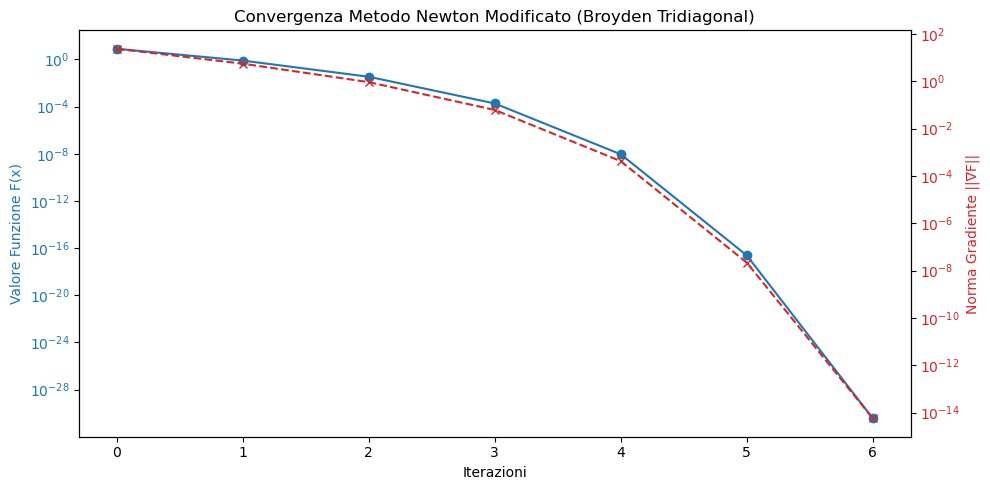

In [76]:
# ---------------------------------------------------------
# 4. GRAFICO CONVERGENZA
# ---------------------------------------------------------
history_f = [broyden_func(xseq[:, i]) for i in range(xseq.shape[1])]
history_g = [npl.norm(broyden_grad(xseq[:, i])) for i in range(xseq.shape[1])]

fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Iterazioni')
ax1.set_ylabel('Valore Funzione F(x)', color=color)
ax1.plot(history_f, color=color, marker='o', label='F(x)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale('log')

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Norma Gradiente ||∇F||', color=color) 
ax2.plot(history_g, color=color, linestyle='--', marker='x', label='||Grad||')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

plt.title('Convergenza Metodo Newton Modificato (Broyden Tridiagonal)')
fig.tight_layout()
plt.show()